In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import wandb

from exercise_code.data.segmentation_dataset import SegmentationData, label_img_to_rgb
from exercise_code.data.download_utils import download_dataset
from exercise_code.util import visualizer, save_model
from exercise_code.util.Util import checkSize, checkParams, test
from exercise_code.networks.segmentation_nn import SegmentationNN, DummySegmentationModel
from exercise_code.tests import test_seg_nn
from tqdm import tqdm
from torch.utils.data import DataLoader


#set up default cuda device
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
device = 'cuda:0'

download_url = 'https://i2dl.vc.in.tum.de/static/data/segmentation_data.zip'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, 'datasets','segmentation')

download_dataset(
    url=download_url,
    data_dir=data_root,
    dataset_zip_name='segmentation_data.zip',
    force_download=False,
)

def train_model(epochs: int, train_loader: DataLoader, val_loader: DataLoader, model: torch.nn.Module, loss_func: torch.nn.Module, optimizer: torch.optim.Optimizer) -> torch.nn.Module:
    model = model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        training_loss = 0.0


        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            images, targets = batch
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            preds = model(images)
            loss = loss_func(preds, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()

        

        torch.cuda.empty_cache()

       # Validation phase
        model.eval()
        validation_loss = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                images, targets = batch
                images, targets = images.to(device), targets.to(device)
                preds = model(images)
                loss = loss_func(preds, targets)
                validation_loss += loss.item()
            

        # Calculate average losses
        train_loss = training_loss / len(train_loader)
        val_loss = validation_loss / len(val_loader)
        print(f'EPOCH [{epoch + 1}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Log the metrics to wandb
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'val_loss': val_loss,
        })

    print('done')
    return model

# Hyperparameters
hparams = {
    'epochs': 70,
    'batch_size': 15,
    'learning_rate': 6e-4,
    'padding' : 1, 
    'stride_down' : 1,
    'stride_up' : 2
}

# Initialize wandb
wandb.init(
    project="my-awesome-project",
    config=hparams
)
wandb.config.learning_rate = hparams['learning_rate']
wandb.config.batch_size = hparams['batch_size']
wandb.config.epochs= hparams['epochs']

# Initialize model, optimizer, loss function, and data loaders
model = SegmentationNN(hp = hparams)
optimizer = torch.optim.Adam(model.parameters(), lr=hparams['learning_rate'])

# Datasets
train_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/train.txt')
val_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/val.txt')
test_data = SegmentationData(image_paths_file=f'{data_root}/segmentation_data/test.txt')

train_loader = DataLoader(train_data, batch_size=hparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_data, batch_size=hparams['batch_size'], shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1,shuffle=False,num_workers=0)

# Loss function 
loss_func = torch.nn.CrossEntropyLoss(ignore_index=-1, reduction='mean')

# Train the model
model = train_model(hparams['epochs'], train_loader, val_loader, model, loss_func, optimizer)


os.makedirs('models', exist_ok=True)
save_model(model, "segmentation_nn.model")







epoch,▁▂▃▄▅▅▆▇█
train_loss,█▆▅▄▃▂▂▂▁
val_loss,█▆▄▃▂▂▁▂▁
epoch,9
train_loss,2.04087
val_loss,1.95669


Validation Epoch 1/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [1/70], Training Loss: 2.8149, Validation Loss: 2.8562


Validation Epoch 2/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [2/70], Training Loss: 2.4085, Validation Loss: 2.4109


Validation Epoch 3/70: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]


EPOCH [3/70], Training Loss: 2.3144, Validation Loss: 2.2170


Validation Epoch 4/70: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


EPOCH [4/70], Training Loss: 2.2216, Validation Loss: 2.2378


Validation Epoch 5/70: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]


EPOCH [5/70], Training Loss: 2.1707, Validation Loss: 2.2723


Validation Epoch 6/70: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


EPOCH [6/70], Training Loss: 2.1144, Validation Loss: 2.1862


Validation Epoch 7/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [7/70], Training Loss: 2.0218, Validation Loss: 1.9162


Validation Epoch 8/70: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


EPOCH [8/70], Training Loss: 1.9734, Validation Loss: 1.8826


Validation Epoch 9/70: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]


EPOCH [9/70], Training Loss: 1.9621, Validation Loss: 1.8863


Validation Epoch 10/70: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


EPOCH [10/70], Training Loss: 1.9481, Validation Loss: 1.9758


Validation Epoch 11/70: 100%|██████████| 4/4 [00:02<00:00,  1.44it/s]


EPOCH [11/70], Training Loss: 1.9200, Validation Loss: 1.9555


Validation Epoch 12/70: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


EPOCH [12/70], Training Loss: 1.9046, Validation Loss: 1.7599


Validation Epoch 13/70: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]


EPOCH [13/70], Training Loss: 1.8268, Validation Loss: 1.7242


Validation Epoch 14/70: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


EPOCH [14/70], Training Loss: 1.8021, Validation Loss: 1.6342


Validation Epoch 15/70: 100%|██████████| 4/4 [00:02<00:00,  1.52it/s]


EPOCH [15/70], Training Loss: 1.7353, Validation Loss: 1.7482


Validation Epoch 16/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [16/70], Training Loss: 1.7874, Validation Loss: 1.6546


Validation Epoch 17/70: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


EPOCH [17/70], Training Loss: 1.7529, Validation Loss: 1.8203


Validation Epoch 18/70: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]


EPOCH [18/70], Training Loss: 1.7284, Validation Loss: 1.7351


Validation Epoch 19/70: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]


EPOCH [19/70], Training Loss: 1.7062, Validation Loss: 1.7207


Validation Epoch 20/70: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s]


EPOCH [20/70], Training Loss: 1.6754, Validation Loss: 1.6445


Validation Epoch 21/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [21/70], Training Loss: 1.6585, Validation Loss: 1.7155


Validation Epoch 22/70: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]


EPOCH [22/70], Training Loss: 1.5670, Validation Loss: 1.5832


Validation Epoch 23/70: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]


EPOCH [23/70], Training Loss: 1.5686, Validation Loss: 1.5939


Validation Epoch 24/70: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


EPOCH [24/70], Training Loss: 1.5867, Validation Loss: 1.6231


Validation Epoch 25/70: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]


EPOCH [25/70], Training Loss: 1.5357, Validation Loss: 1.6691


Validation Epoch 26/70: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


EPOCH [26/70], Training Loss: 1.5174, Validation Loss: 1.5599


Validation Epoch 27/70: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s]


EPOCH [27/70], Training Loss: 1.4775, Validation Loss: 1.4411


Validation Epoch 28/70: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]


EPOCH [28/70], Training Loss: 1.4858, Validation Loss: 1.4572


Validation Epoch 29/70: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


EPOCH [29/70], Training Loss: 1.4292, Validation Loss: 1.4999


Validation Epoch 30/70: 100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


EPOCH [30/70], Training Loss: 1.3445, Validation Loss: 1.4071


Validation Epoch 31/70: 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


EPOCH [31/70], Training Loss: 1.4169, Validation Loss: 1.3741


Training Epoch 32/70:   5%|▌         | 1/19 [00:01<00:19,  1.11s/it]

In [ ]:
def evaluate_model(model, dataloader):
    test_scores = []
    model.eval()
    model = model.to(device)
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model.forward(inputs)
        _, preds = torch.max(outputs, 1)
        targets_mask = (targets >= 0).cpu()
        test_scores.append(np.mean((preds.cpu() == targets.cpu())[targets_mask].numpy()))

    return np.mean(test_scores)


model.to(torch.device('cuda'))
device = torch.device('cuda')
test(evaluate_model(model, test_loader))



Validation-Accuracy: 56.39745333459205%
That's too low! Please tune your model in order to reach at least 60.0% before running on the test set and submitting!


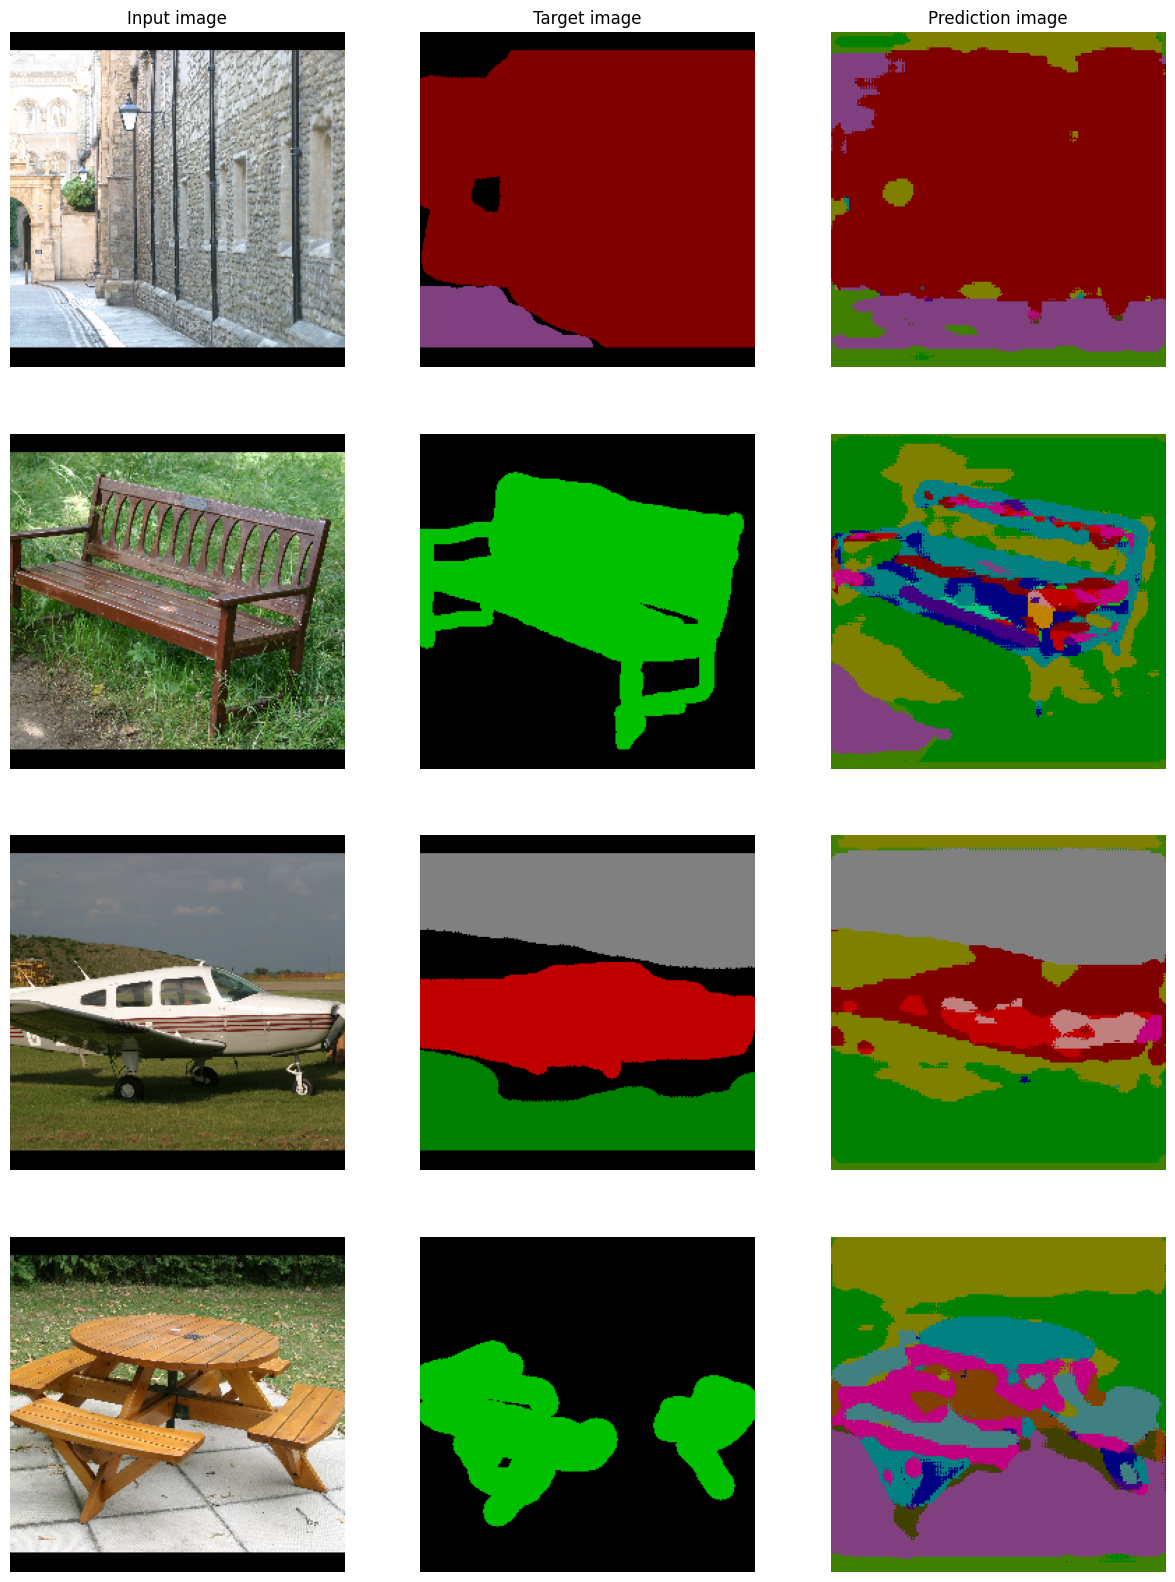

In [ ]:

visualizer(model, test_data)